# Analisi rapida `prod_interactions.csv` (semplice)
Autori: **Dicorato Martina**, **Kirollos Seif** — Versione 1.0

Notebook **semplice e funzionale** per guardare i dati provenienti dal sito di produzione.


In [29]:
# === Path progetto e CSV ===
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 160)

def find_project_root():
    here = Path.cwd().resolve()
    for p in [here, *here.parents]:
        if (p / "data").is_dir() and (p / "src").is_dir():
            return p
    # fallback al tuo percorso noto su Windows
    return Path(r"C:\Users\MARTINADICORATO\Diabete_New\Diabete")

PROJECT_ROOT = find_project_root()
DATA_DIR = PROJECT_ROOT / "data"
CSV_PATH = DATA_DIR / "prod_interactions.csv"

# Se non esiste, tenta una ricerca rapida
if not CSV_PATH.exists():
    try:
        CSV_PATH = next(PROJECT_ROOT.rglob("prod_interactions.csv"))
    except StopIteration:
        raise FileNotFoundError(f"Non trovo prod_interactions.csv sotto {PROJECT_ROOT}")

print("PROJECT_ROOT:", PROJECT_ROOT)
print("CSV:", CSV_PATH)

PROJECT_ROOT: C:\Users\MARTINADICORATO
CSV: C:\Users\MARTINADICORATO\Downloads\prod_interactions.csv


In [30]:
# === Caricamento dati ===
df = pd.read_csv(CSV_PATH)
print("Righe:", len(df))
if "timestamp" in df.columns:
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce", utc=True)
df.head(8)

Righe: 2


,timestamp,session_id,event_type,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,predicted_class,probability,comune,ospedale,telefono,indirizzo,prenotazioni,note
0,2025-08-24 22:03:34+00:00,2b9f30fb-340a-4d21-8d5b-9e879c86b6bb,prediction,0,0,0,24.2,0,0,0,0,0,0,0,0,0,3,2,2,0,0,40,4,4,0,0.9316,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-08-24 22:04:06+00:00,2b9f30fb-340a-4d21-8d5b-9e879c86b6bb,contact_view,0,0,0,24.2,0,0,0,0,0,0,0,0,0,3,2,2,0,0,40,4,4,0,0.9316,Abbiategrasso,Policlinico di Milano (Ca’ Granda),+39 02 5503.1 (H24),"Via Francesco Sforza 28, Milano",Numero Verde Regionale: 800 638 638 (fisso) / ...,IRCCS; centro; include Clinica Mangiagalli


## Panoramica colonne e missing

In [31]:
print("Colonne:", list(df.columns))
missing = df.isna().mean().sort_values(ascending=False)
missing.head(12)

Colonne: ['timestamp', 'session_id', 'event_type', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income', 'predicted_class', 'probability', 'comune', 'ospedale', 'telefono', 'indirizzo', 'prenotazioni', 'note']


note               0.5
prenotazioni       0.5
indirizzo          0.5
telefono           0.5
ospedale           0.5
comune             0.5
session_id         0.0
probability        0.0
predicted_class    0.0
Income             0.0
Education          0.0
Age                0.0
dtype: float64

## Eventi per tipo

event_type
prediction      1
contact_view    1
Name: count, dtype: int64

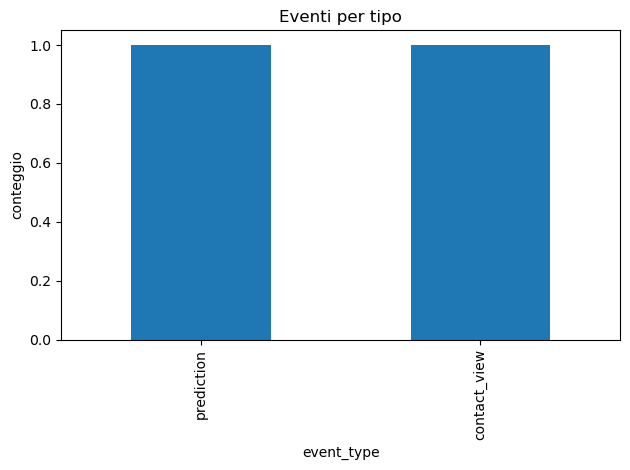

In [32]:
if "event_type" in df.columns:
    vc = df["event_type"].value_counts()
    display(vc)
    plt.figure()
    vc.plot(kind="bar")
    plt.title("Eventi per tipo")
    plt.xlabel("event_type"); plt.ylabel("conteggio")
    plt.tight_layout(); plt.show()
else:
    print("Colonna 'event_type' non presente.")

## Eventi per giorno

timestamp
2025-08-24 00:00:00+00:00    2
Freq: D, dtype: int64

c:\Users\MARTINADICORATO\OneDrive - ITS Tech Talent Factory\Documenti\ANACOND\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1567: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)


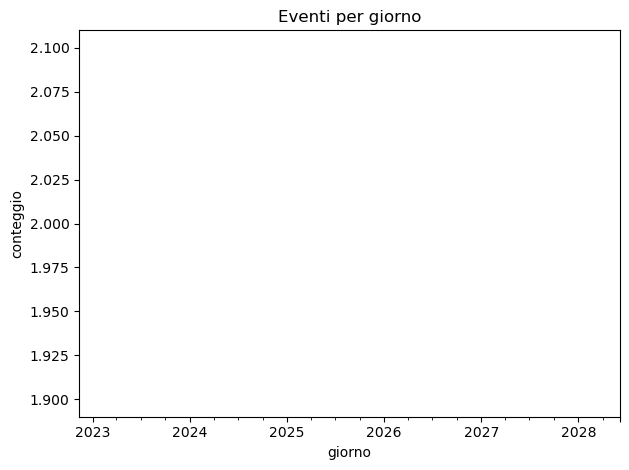

In [33]:
if "timestamp" in df.columns and df["timestamp"].notna().any():
    daily = df.set_index("timestamp").resample("D").size()
    display(daily.tail(10))
    plt.figure()
    daily.plot()
    plt.title("Eventi per giorno")
    plt.xlabel("giorno"); plt.ylabel("conteggio")
    plt.tight_layout(); plt.show()
else:
    print("Manca 'timestamp' o nessun valore valido.")

## Distribuzione classi predette (torta)

predicted_class
0    2
1    0
2    0
Name: count, dtype: int64


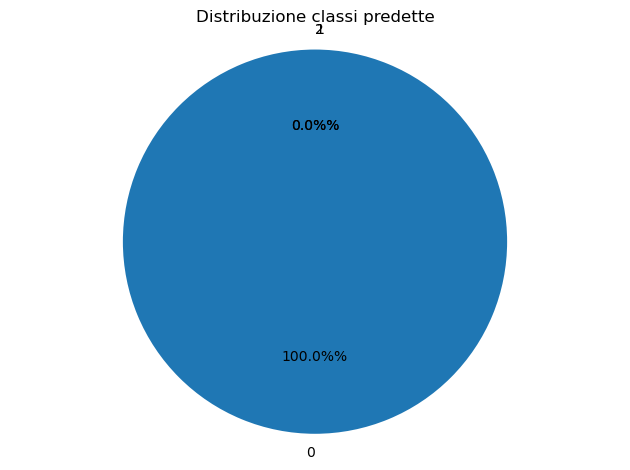

In [34]:
if "predicted_class" in df.columns:
    counts = (df["predicted_class"]
              .dropna()
              .astype(float)
              .astype(int)
              .value_counts()
              .reindex([0,1,2], fill_value=0))
    total = counts.sum()
    print(counts)
    if total > 0:
        plt.figure()
        plt.pie(counts, labels=["0","1","2"], autopct=lambda p: f"{p:.1f}%%", startangle=90)
        plt.title("Distribuzione classi predette")
        plt.axis("equal")
        plt.tight_layout(); plt.show()
    else:
        print("Nessun valore in predicted_class.")
else:
    print("Colonna 'predicted_class' non presente.")

## Comuni più cercati (solo contact_view)

comune
Abbiategrasso    1
Name: count, dtype: int64

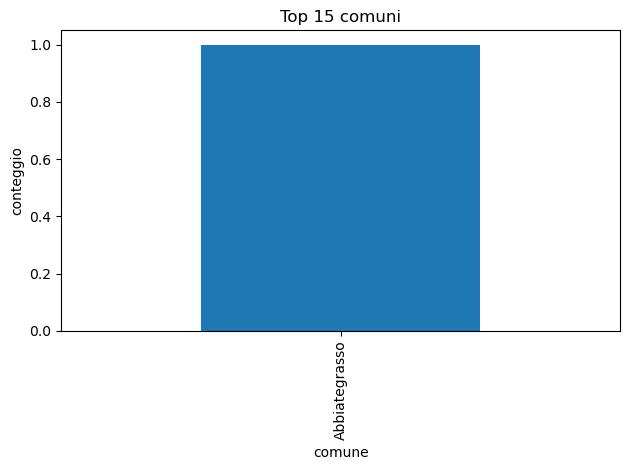

In [35]:
if set(["event_type","comune"]).issubset(df.columns):
    sub = df[df["event_type"]=="contact_view"]
    top = (sub["comune"].dropna().astype(str).str.strip().value_counts().head(15))
    display(top)
    if not top.empty:
        plt.figure()
        top.plot(kind="bar")
        plt.title("Top 15 comuni")
        plt.xlabel("comune"); plt.ylabel("conteggio")
        plt.tight_layout(); plt.show()
    else:
        print("Nessun contact_view con comune valorizzato.")
else:
    print("Servono 'event_type' e 'comune'.")

## Minuti da prediction a primo contact_view

count    1.000000
mean     0.533333
std           NaN
min      0.533333
25%      0.533333
50%      0.533333
75%      0.533333
max      0.533333
Name: minutes, dtype: float64


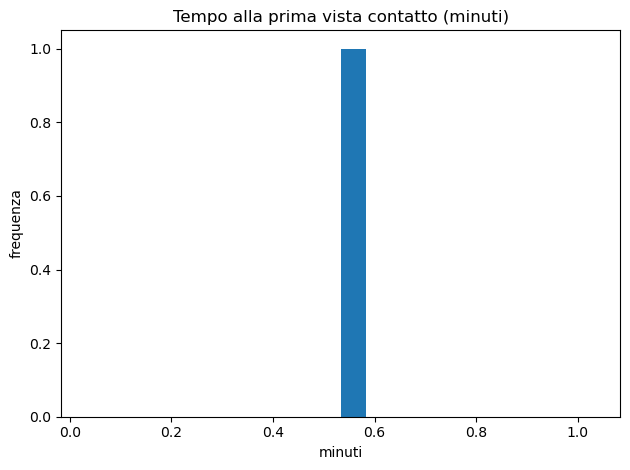

In [36]:
if set(["session_id","event_type","timestamp"]).issubset(df.columns):
    d = df.sort_values(["session_id","timestamp"])
    deltas = []
    for sid, g in d.groupby("session_id"):
        t1 = g.loc[g["event_type"]=="prediction", "timestamp"]
        t2 = g.loc[g["event_type"]=="contact_view", "timestamp"]
        if len(t1)>0 and len(t2)>0:
            dt = (t2.iloc[0] - t1.iloc[0]).total_seconds()/60.0
            if dt >= 0:
                deltas.append(dt)
    if deltas:
        s = pd.Series(deltas, name="minutes")
        print(s.describe())
        plt.figure()
        s.plot(kind="hist", bins=20)
        plt.title("Tempo alla prima vista contatto (minuti)")
        plt.xlabel("minuti"); plt.ylabel("frequenza")
        plt.tight_layout(); plt.show()
    else:
        print("Nessuna coppia prediction→contact_view trovata.")
else:
    print("Servono 'session_id', 'event_type', 'timestamp'.")

## (Opzionale) Scatter BMI vs. Probabilità

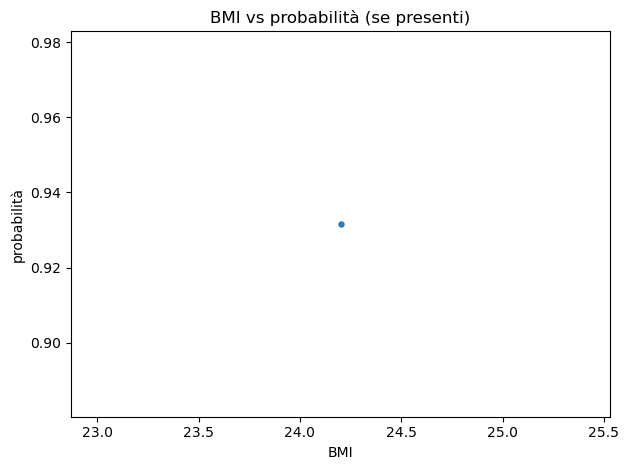

In [37]:
if set(["BMI","probability"]).issubset(df.columns):
    try:
        x = pd.to_numeric(df["BMI"], errors="coerce")
        y = pd.to_numeric(df["probability"], errors="coerce")
        ok = x.notna() & y.notna()
        plt.figure()
        plt.scatter(x[ok], y[ok], s=12, alpha=0.7)
        plt.title("BMI vs probabilità (se presenti)")
        plt.xlabel("BMI"); plt.ylabel("probabilità")
        plt.tight_layout(); plt.show()
    except Exception as e:
        print("Impossibile disegnare lo scatter:", e)
else:
    print("Servono 'BMI' e 'probability'.")

## Esportazioni semplici

In [38]:
metrics_dir = CSV_PATH.parent / "metrics"
plots_dir = metrics_dir / "plots"
metrics_dir.mkdir(parents=True, exist_ok=True)
plots_dir.mkdir(parents=True, exist_ok=True)

# Eventi per giorno
if "timestamp" in df.columns and df["timestamp"].notna().any():
    daily = df.set_index("timestamp").resample("D").size().rename("count").reset_index()
    daily.to_csv(metrics_dir / "prod_events_per_day.csv", index=False)

# Top comuni
if set(["event_type","comune"]).issubset(df.columns):
    sub = df[df["event_type"]=="contact_view"]
    if not sub.empty:
        top_comuni = sub["comune"].dropna().astype(str).str.strip().value_counts().reset_index()
        top_comuni.columns = ["comune","count"]
        top_comuni.to_csv(metrics_dir / "prod_top_comuni.csv", index=False)

print("Salvati CSV in:", metrics_dir)

Salvati CSV in: C:\Users\MARTINADICORATO\Downloads\metrics
